# Python II - Group Assignment - Modcloth (Sample Dataset 2)
## An approach to detecting and understanding machine learning biases using classes

Congregating the various theoretical concepts into a practical framework, we can follow the “theoretical lens of a ‘sense-plan-act’ cycle”, as described by the HLEG framework (European Commission and Directorate-General for Communications Networks, Content and Technology, 2019). Applying this concept to the problem of ML fairness, we can break down three core steps in providing robust, and responsible artificial intelligence: Identify, Understand, and Act (IUA).

1. __Identify__: The process of exposing direct or indirect biases within a dataset and/or model.
1. __Understand__: The process of isolating impactful scenarios and obtaining trans parent explanations for outcomes.
1. __Act__: The process of reporting and rectifying identified disparities within the

By understanding the philosophical forms of unfairness as defined by our review of the literature and categorizing our prominent fairness metrics into the overarching categories of representation, ability, and performance, we can establish a series of tests to “identify” levels of disparities between sensitive groups at different levels. Merging these findings with the explainability of our models through the use of white-box models, or Shapley value estimation for black-box models, we can dig deeper into the model’s predictions, “understanding” how classifications were made, and how they varied from the natural dataset exposing both natural biases as well as added model differences. Finally, by probing further into levels of misclassification, in particular looking at negative outcomes, we can isolate groups most at risk and set up a series of “actions” that can be taken to mitigate the effects. Given this three-step framework which combines societal, legal, and technical considerations, the paper will then go through a series of cases, and examine the proposed framework.

# Let's use fairdetect_functions to find biases
For using fairdetect_functions we need create a model, for this we will:
1. __load the functions__ from fairdetect_functions
1. then __load a dataset__, in this case we will use: german dataser from https://dalex.drwhy.ai/python/api/datasets/index.html
/  Dataset 'german' contains information about people and their credit risk. On the base of age, purpose, credit amount, job, sex, etc. the model should predict the target - risk. risk tells if the credit rate will be good (1) or bad (0). This data contains some bias and it can be detected using the dalex.fairness module.
1. then __clean and prepare the dataset__ for modeling, in this case we only need to apply label enconding in order to transform text into numeric variables.
1. then we __split the data in train and test sets__
1. then we __build a model__, in this case we applying a Machine Learning (ML) model called XGBoost Classifier. The reason for choosing a ML is that ML models are harded to visualize, sometimes called Black Box models, what makes very difficult to see if any bias is present in the model.

In [29]:
# Creating our classes

class bias_detection:
    def __init__(self,model,X_test,y_test):
        self.model,self.X_test,self.y_test= model, X_test, y_test

    def create_labels(self,sensitive):
        sensitive_label = {}
        for i in set(self.X_test[sensitive]):
            text = "Please Enter Label for Group" +" "+ str(i)+": "
            label = input(text)
            sensitive_label[i]=label
        return(sensitive_label)

    def representation(self,X_test,y_test,sensitive,labels,predictions):
        full_table = X_test.copy()
        sens_df = {}

        for i in labels:
            full_table['p'] = predictions
            full_table['t'] = y_test
            sens_df[labels[i]] = full_table[full_table[sensitive]==i]

        contigency_p = pd.crosstab(full_table[sensitive], full_table['t']) 
        cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
        contigency_pct_p = pd.crosstab(full_table[sensitive], full_table['t'], normalize='index')

        sens_rep = {}
        for i in labels:
            sens_rep[labels[i]] = (X_test[sensitive].value_counts()/X_test[sensitive].value_counts().sum())[i]

        labl_rep = {}
        for i in labels:
            labl_rep[str(i)] = (y_test.value_counts()/y_test.value_counts().sum())[i]


        fig = make_subplots(rows=1, cols=2)

        for i in labels:
            fig.add_trace(go.Bar(
            showlegend=False,
            x = [labels[i]],
            y= [sens_rep[labels[i]]]),row=1,col=1)

            fig.add_trace(go.Bar(
            showlegend=False,
            x = [str(i)],
            y= [labl_rep[str(i)]],
            marker_color=['orange','blue'][i]),row=1,col=2)

        c, p, dof, expected = chi2_contingency(contigency_p)
        cont_table = (tabulate(contigency_pct_p.T, headers=labels.values(), tablefmt='fancy_grid'))

        return cont_table, sens_df, fig, p



    def ability(self,sens_df,labels):
        sens_conf = {}
        for i in labels:
            sens_conf[labels[i]] = confusion_matrix(list(sens_df[labels[i]]['t']), list(sens_df[labels[i]]['p']), labels=[0,1]).ravel()

        true_positive_rate = {}
        false_positive_rate = {}
        true_negative_rate = {}
        false_negative_rate = {}

        for i in labels:
            true_positive_rate[labels[i]] = (sens_conf[labels[i]][3]/(sens_conf[labels[i]][3]+sens_conf[labels[i]][2]))
            false_positive_rate[labels[i]] = (sens_conf[labels[i]][1]/(sens_conf[labels[i]][1]+sens_conf[labels[i]][0]))
            true_negative_rate[labels[i]] = 1 - false_positive_rate[labels[i]]
            false_negative_rate[labels[i]] = 1 - true_positive_rate[labels[i]]

        return(true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate)



    def ability_plots(self, labels,TPR,FPR,TNR,FNR):
        fig = make_subplots(rows=2, cols=2, 
                            subplot_titles=("True Positive Rate", "False Positive Rate", "True Negative Rate", "False Negative Rate"))

        x_axis = list(labels.values())
        fig.add_trace(
            go.Bar(x = x_axis, y=list(TPR.values())),
            row=1, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FPR.values())),
            row=1, col=2
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(TNR.values())),
            row=2, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FNR.values())),
            row=2, col=2
        )

        fig.update_layout(showlegend=False,height=600, width=800, title_text="Ability Disparities")
        fig.show()

    def ability_metrics(self,TPR,FPR,TNR,FNR):
        TPR_p = chisquare(list(np.array(list(TPR.values()))*100))[1]
        FPR_p = chisquare(list(np.array(list(FPR.values()))*100))[1]
        TNR_p = chisquare(list(np.array(list(TNR.values()))*100))[1]
        FNR_p = chisquare(list(np.array(list(FNR.values()))*100))[1]

        if TPR_p <= 0.01:
            print("*** Reject H0: Significant True Positive Disparity with p=",TPR_p)
        elif TPR_p <= 0.05:
            print("** Reject H0: Significant True Positive Disparity with p=",TPR_p)
        elif TPR_p <= 0.1:
            print("*  Reject H0: Significant True Positive Disparity with p=",TPR_p)
        else:
            print("Accept H0: True Positive Disparity Not Detected. p=",TPR_p)

        if FPR_p <= 0.01:
            print("*** Reject H0: Significant False Positive Disparity with p=",FPR_p)
        elif FPR_p <= 0.05:
            print("** Reject H0: Significant False Positive Disparity with p=",FPR_p)
        elif FPR_p <= 0.1:
            print("*  Reject H0: Significant False Positive Disparity with p=",FPR_p)
        else:
            print("Accept H0: False Positive Disparity Not Detected. p=",FPR_p)

        if TNR_p <= 0.01:
            print("*** Reject H0: Significant True Negative Disparity with p=",TNR_p)
        elif TNR_p <= 0.05:
            print("** Reject H0: Significant True Negative Disparity with p=",TNR_p)
        elif TNR_p <= 0.1:
            print("*  Reject H0: Significant True Negative Disparity with p=",TNR_p)
        else:
            print("Accept H0: True Negative Disparity Not Detected. p=",TNR_p)

        if FNR_p <= 0.01:
            print("*** Reject H0: Significant False Negative Disparity with p=",FNR_p)
        elif FNR_p <= 0.05:
            print("** Reject H0: Significant False Negative Disparity with p=",FNR_p)
        elif FNR_p <= 0.1:
            print("*  Reject H0: Significant False Negative Disparity with p=",FNR_p)
        else:
            print("Accept H0: False Negative Disparity Not Detected. p=",FNR_p)




    def predictive(self,labels,sens_df):
        precision_dic = {}

        for i in labels:
            precision_dic[labels[i]] = precision_score(sens_df[labels[i]]['t'],sens_df[labels[i]]['p'])

        fig = go.Figure([go.Bar(x=list(labels.values()), y=list(precision_dic.values()))])

        pred_p = chisquare(list(np.array(list(precision_dic.values()))*100))[1]

        return(precision_dic,fig,pred_p)




    def identify_bias(self,sensitive,labels):
        predictions = self.model.predict(self.X_test)
        cont_table,sens_df,rep_fig,rep_p = self.representation(self.X_test,self.y_test,sensitive,labels,predictions)

        print("REPRESENTATION")
        rep_fig.show()

        print(cont_table,'\n')

        if rep_p <= 0.01:
            print("*** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        elif rep_p <= 0.05:
            print("** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        elif rep_p <= 0.1:
            print("* Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        else:
            print("Accept H0: No Significant Relation Between",sensitive,"and Target Detected. p=",rep_p)

        TPR, FPR, TNR, FNR = self.ability(sens_df,labels)
        print("\n\nABILITY")
        self.ability_plots(labels,TPR,FPR,TNR,FNR)
        self.ability_metrics(TPR,FPR,TNR,FNR)


        precision_dic, pred_fig, pred_p = self.predictive(labels,sens_df)
        print("\n\nPREDICTIVE")
        pred_fig.show()

        if pred_p <= 0.01:
            print("*** Reject H0: Significant Predictive Disparity with p=",pred_p)
        elif pred_p <= 0.05:
            print("** Reject H0: Significant Predictive Disparity with p=",pred_p)
        elif pred_p <= 0.1:
            print("* Reject H0: Significant Predictive Disparity with p=",pred_p)
        else:
            print("Accept H0: No Significant Predictive Disparity. p=",pred_p)


    def understand_shap(self,labels,sensitive,affected_group,affected_target):
        import shap
        explainer = shap.Explainer(self.model)

        full_table = self.X_test.copy()
        full_table['t'] = self.y_test
        full_table['p'] = self.model.predict(X_test)
        full_table

        shap_values = explainer(self.X_test)
        sens_glob_coh = np.where(self.X_test[sensitive]==list(labels.keys())[0],labels[0],labels[1])

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        #sens_mis_coh = np.where(affected_class[sensitive]==list(labels.keys())[0],labels[0],labels[1])


        figure,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
        plt.subplots_adjust(right=1.4,wspace=1)

        print("Model Importance Comparison")
        plt.subplot(1, 2, 1) # row 1, col 2 index 1
        shap.plots.bar(shap_values.cohorts(sens_glob_coh).abs.mean(0),show=False)
        plt.subplot(1, 2, 2) # row 1, col 2 index 1
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        shap.plots.bar(shap_values2)
        #shap.plots.bar(shap_values2)

        full_table['t'] = y_test
        full_table['p'] = self.model.predict(self.X_test)
        #full_table=full_table[['checking_account','credit_amount','duration','sex','t','p']]

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        truclass = full_table[full_table.t == full_table.p]
        tru_class = truclass[(truclass[sensitive] == affected_group) & (truclass.t == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-tru_class.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])

        print("Affected Attribute Comparison")
        print("Average Comparison to True Class Members")
        fig.show()

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        #truclass = full_table[full_table.t == full_table.p]
        tru_class = full_table[(full_table[sensitive] == affected_group) & (full_table.p == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-full_table.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])
        print("Average Comparison to All Members")
        fig.show()

        print("Random Affected Decision Process")
        explainer = shap.Explainer(model)
        shap.plots.waterfall(explainer(affected_class.drop(['t','p'],axis=1))[randrange(0, len(affected_class))],show=False)


In [30]:
# Importing our Libraries

import matplotlib.pyplot as plt
from random import randrange
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import dalex as dx
import pandas as pd
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare
from sklearn.metrics import precision_score
#import fairdetect_functions as fd
from __future__ import print_function

In [31]:
# Loading our DataFrame
data = pd.read_csv('modcloth.csv')
data

,item_id,user_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,year,split
0,7443,Alex,4,2010-01-21 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
1,7443,carolyn.agan,3,2010-01-27 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
2,7443,Robyn,4,2010-01-29 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
3,7443,De,4,2010-02-13 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
4,7443,tasha,4,2010-02-18 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99888,154797,BernMarie,5,2019-06-26 21:15:13.165000+00:00,6.0,Just right,Large,Small&Large,Dresses,NaN,2017,0
99889,77949,Sam,4,2019-06-26 23:22:29.633000+00:00,4.0,Slightly small,Small,Small&Large,Bottoms,NaN,2014,2
99890,67194,Janice,5,2019-06-27 00:20:52.125000+00:00,NaN,Just right,Small,Small&Large,Dresses,NaN,2013,2
99891,71607,amy,3,2019-06-27 15:45:06.250000+00:00,NaN,Slightly small,Small,Small&Large,Outerwear,Jack by BB Dakota,2016,2


In [32]:
data.drop(['split','timestamp','year','item_id','user_id'], axis=1,inplace= True)

In [33]:
data

,rating,size,fit,user_attr,model_attr,category,brand
0,4,NaN,NaN,Small,Small,Dresses,NaN
1,3,NaN,NaN,NaN,Small,Dresses,NaN
2,4,NaN,NaN,Small,Small,Dresses,NaN
3,4,NaN,NaN,NaN,Small,Dresses,NaN
4,4,NaN,NaN,Small,Small,Dresses,NaN
...,...,...,...,...,...,...,...
99888,5,6.0,Just right,Large,Small&Large,Dresses,NaN
99889,4,4.0,Slightly small,Small,Small&Large,Bottoms,NaN
99890,5,NaN,Just right,Small,Small&Large,Dresses,NaN
99891,3,NaN,Slightly small,Small,Small&Large,Outerwear,Jack by BB Dakota


In [34]:
data3= data.dropna(subset=['user_attr'])

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data3['model_attr'] = le.fit_transform(data3['model_attr'])
data3['category'] = le.fit_transform(data3['category'])
data3['brand'] = le.fit_transform(data3['brand'])
data3['user_attr'] = le.fit_transform(data3['user_attr'])
data3['fit'] = le.fit_transform(data3['fit'])
data3

,rating,size,fit,user_attr,model_attr,category,brand
0,4,NaN,5,1,0,1,31
2,4,NaN,5,1,0,1,31
4,4,NaN,5,1,0,1,31
6,2,NaN,5,1,0,1,31
8,4,NaN,5,1,0,1,31
...,...,...,...,...,...,...,...
99888,5,6.0,0,0,1,1,31
99889,4,4.0,2,1,1,0,31
99890,5,NaN,0,1,1,1,31
99891,3,NaN,2,1,1,2,13


# Data Cleaning
## Transforming/ Binarizing

## Splitting the data into train and test

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
X = data3.drop(["model_attr"],axis=1) # axis: {0 or ‘index’, 1 or ‘columns’}, default 0
y = data3["model_attr"]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
print("Data sucessfully loaded!")

Data sucessfully loaded!


## Training a machine learning model

In [38]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_test_predict = model.predict(X_test)
y_test_predict

array([0, 0, 1, ..., 1, 1, 0])

## Creationg the Object

In [39]:
bd = bias_detection(model,X_test,y_test)

# Bias Detection
## Representation of Sensitive Variables

### Create Lables

In [40]:
sensitive = 'user_attr' # sensible variable one wants to test for biases

In [41]:
labels = bd.create_labels(sensitive) # create lables for sensitive group that we have selected above

Please Enter Label for Group 0: Large
Please Enter Label for Group 1: Small


In [42]:
bd.identify_bias(sensitive,labels)

REPRESENTATION


╒════╤══════════╤══════════╕
│    │    Large │    Small │
╞════╪══════════╪══════════╡
│  0 │ 0.376712 │ 0.433816 │
├────┼──────────┼──────────┤
│  1 │ 0.623288 │ 0.566184 │
╘════╧══════════╧══════════╛ 

*** Reject H0: Significant Relation Between user_attr and Target with p= 4.6444437573191055e-10


ABILITY


Accept H0: True Positive Disparity Not Detected. p= 0.5147213613405428
Accept H0: False Positive Disparity Not Detected. p= 0.45014513815392176
Accept H0: True Negative Disparity Not Detected. p= 0.4022546913658618
Accept H0: False Negative Disparity Not Detected. p= 0.1498244800695896


PREDICTIVE


Accept H0: No Significant Predictive Disparity. p= 0.7226799947800719


The analysis is split in 3 parts in order to identify areas of bias. It will break down identification of bias into 3 sessions

**ModCloth:** is an e-commerce website which sells women’s clothing and accessories. One unique property of this data is that many products include two human models with different body shapes (as shown in Figure 1) and measurements of these models. In addition, users can optionally provide the product sizes they purchased and fit feedback (‘Just Right’, ‘Slightly Larger’, ‘Larger’, ‘Slightly Smaller’ or ‘Smaller’) along with their reviews. Therefore we focus on the dimension of human body shape as the source of marketing bias in this dataset.

**User Identity Group (Body Shape):** We then calculate the average size each user purchased and classify users into ‘Small’ and ‘Large’ groups based on the same standard as the product body shape image.

**Product Image explained:** Products with only one human model wearing a relatively small size (‘XS’, ‘S’, ‘M’ or ‘L’) are labeled as the ‘Small’ group while products with two models (an additional model wearing a plus-size: 1X’, ‘2X’, ‘3X’ or ‘4X’) are referred as the ‘Small&Large’ group.

**REPRESENTATON:** Comparison of the sensitive attribute User Identity Group (Large=0 and Small=1) and the target variable (Model Attribute: Product Image: Small=0, Small&large=1). 

- User Identity is an unbalanced class, with users identified with identity group large equals to 20% and and those identified with small equals 80%
- Product Immage Attribute: 0 for small and 1 for small&large. 42% of observations landing in smal and 58% in small&large.

Demographic Parity: association of the target variable v.s. the sensitive variable

- Large in group 0 (large size as user identity group v.s product image small): 37% of users with large size as identity group  are exposed to a small product image.
- Large in group 1 (large size as user identity group v.s product image small&large): 62% of users with large size as identity group  are exposed to a small&large product image.
- Small in group 0 ( small size as user identity group v.s product image small): 43% of users with small size as identity group  are exposed to a small product image.
- Small in group 1 (small size as user identity group v.s product image small&large): 57% of users with small size as identity group  are exposed to a small&large product image.

P-Value: Reject the null Hipothesis of non significance relation between the sensitive variable and the target variable. This means THERE IS a relationship between the user identity and the product image.

**ABILITY:** Analysing specific sensitive groups
Regardless of the sensitive background, there should be a 50/50 ratio in a fair scenario. With the false negative rate there is a significant difference betweek large and small, however not enought to reject our null hypothesis


    **PREDICTION:** The model is not further exacervating the anyobserveb bias. Whatever is present in the dataset is observed in the predicitions.


## Model Importance Comparison

Model Importance Comparison


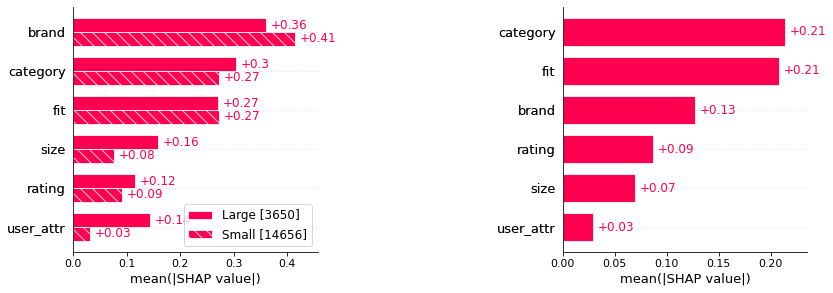

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process


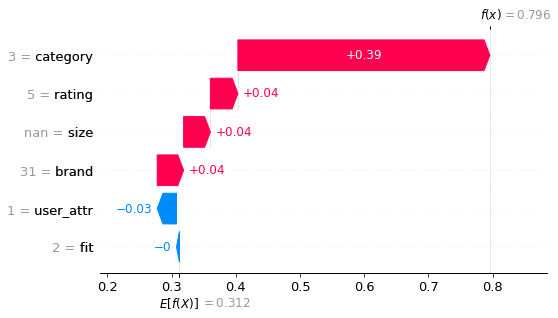

In [45]:
bd.understand_shap(labels,sensitive,1,1)

For small size user identiy group, brand is more important that for large size user identity group, while fit is the more relevant varable for the affected group (Small
